In [1]:
cd drive/MyDrive/Colab\ Notebooks/GSOC\ 2021/ML4Sci

/content/drive/MyDrive/Colab Notebooks/GSOC 2021/ML4Sci


In [4]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
from keras.models import Sequential
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal, RandomUniform
from keras import regularizers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.constraints import max_norm
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import Normalizer, StandardScaler


from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

In [5]:
lr_init     = 1.e-3    # Initial learning rate
batch_size  = 100       # Training batch size
train_size  = 229000    # Training size
valid_size  = 6000    # Validation size
test_size   = 14000     # Test size
epochs      = 40       # Number of epochs
doGPU       = False    # Use GPU

In [6]:
if doGPU:
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

In [7]:
## Load Data
img_rows, img_cols, nb_channels = 32, 32, 2
input_dir = 'data'
decays = ['Photon', 'Electron']

In [8]:
def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s.hdf5'%(decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

In [9]:
# Configure Training/Validation/Test Sets

# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)
#X_train, y_train = X,y
X_train_norm = np.zeros_like(X_train)
for i in range(train_size):
    try:
        X_train_norm[i, :, :, 0] = StandardScaler().fit_transform(X=X_train[i, :, :, 0])
        X_train_norm[i, :, :, 1] = StandardScaler().fit_transform(X=X_train[i, :, :, 1])
    except:
        print('train',i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# Set range of validation set
valid_start, valid_stop = 229000,229000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)
X_valid_norm = np.zeros_like(X_valid)
for i in range(valid_size):
    try:
        X_valid_norm[i, :, :, 0] = StandardScaler().fit_transform(X=X_valid[i, :, :, 0])
        X_valid_norm[i, :, :, 1] = StandardScaler().fit_transform(X=X_valid[i, :, :, 1])
    except:
        print('valid', i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# Set range of test set
test_start, test_stop = 235000, 235000+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)
X_test_norm = np.zeros_like(X_test)
for i in range(test_size):
    try:
        X_test_norm[i, :, :, 0] = StandardScaler().fit_transform(X=X_test[i, :, :, 0])
        X_test_norm[i, :, :, 1] = StandardScaler().fit_transform(X=X_test[i, :, :, 1])
    except:
        print('test', i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
mu = X_train.mean()
std = X_train.std()

X_train = (X_train - mu) / std
X_valid = (X_valid - mu) / std
X_test = (X_test - mu) / std

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

In [13]:
# ## Define CNN model
model = Sequential()
model.add(Conv2D(8, activation='relu', kernel_size=3, padding='same', kernel_initializer='GlorotNormal', input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(8, activation='relu', kernel_size=3, padding='same', kernel_initializer='GlorotNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='GlorotNormal'))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='GlorotNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', kernel_size=5, padding='same', kernel_initializer='GlorotNormal'))
model.add(Conv2D(32, activation='relu', kernel_size=5, padding='same', kernel_initializer='GlorotNormal'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='GlorotNormal'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer='GlorotNormal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='GlorotNormal'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         152       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        2336      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          2

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Epoch 1/40
4580/4580 [==============================] - 58s 6ms/step - loss: 0.6528 - accuracy: 0.6151 - val_loss: 0.6141 - val_accuracy: 0.6702
Epoch 2/40
4580/4580 [==============================] - 24s 5ms/step - loss: 0.5842 - accuracy: 0.7004 - val_loss: 0.6050 - val_accuracy: 0.6913
Epoch 3/40
4580/4580 [==============================] - 24s 5ms/step - loss: 0.5668 - accuracy: 0.7151 - val_loss: 0.5676 - val_accuracy: 0.7134
Epoch 4/40
4580/4580 [==============================] - 24s 5ms/step - loss: 0.5609 - accuracy: 0.7190 - val_loss: 0.5613 - val_accuracy: 0.7209
Epoch 5/40
4580/4580 [==============================] - 24s 5ms/step - loss: 0.5578 - accuracy: 0.7228 - val_loss: 0.5626 - val_accuracy: 0.7183
Epoch 6/40
4580/4580 [==============================] - 24s 5ms/step - loss: 0.5542 - accuracy: 0.7253 - val_loss: 0.5550 - val_accuracy: 0.7233
Epoch 7/40
4580/4580 [==============================] - 24s 5ms/step - loss: 0.5523 - accuracy: 0.7265 - val_loss: 0.5529 - val_ac

In [15]:
# Save Trained neural network
model.save('CNNmodel3.h5')

# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

375/375 [==============================] - 1s 3ms/step - loss: 0.5404 - accuracy: 0.7324

Validation loss / accuracy: 0.5404 / 0.7324
Validation ROC AUC: 0.8027767916666666
875/875 [==============================] - 2s 3ms/step - loss: 0.5361 - accuracy: 0.7379

Test loss / accuracy: 0.5361 / 0.7379
Test ROC AUC: 0.8068678647959184


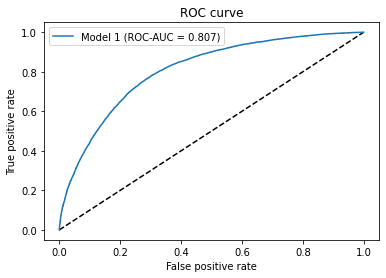

In [16]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()